# Mustererkennung/Machine Learning - Assignment 9

### Load the spam dataset:

In [98]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random
from tqdm import tqdm

In [99]:
def to_one_hot(y, num_classes):
    return np.eye(num_classes)[y.astype(np.uint)]

num_classes = 10

path_to_train = 'zip.train'
path_to_test = 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

y_train, y_test = to_one_hot(y_train, num_classes), to_one_hot(y_test, num_classes)

In [100]:
def softmax(x):
    exp = np.exp(x)
    summed = np.sum(exp, axis=1, keepdims=True)
    return exp / summed

def accuracy(y_true, y_pred):
    """
    y_true should be a one hot encoded vector.
    """
    #print()
    #print(y_true.shape)
    #print(y_pred.shape)
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    #print(y_true)
    #print(y_pred)
    #print()
    return np.mean(y_true == y_pred)

class Sigmoid():
    def forward(self, x):
        x = np.clip(x, -500, 500)
        eps = 10 ** -10
        z = 1.0 / (1.0 + np.exp(-x))
        self.z = z + eps
        return z
    
    def backward(self, right_dev):
        return (self.z / (1.0 - self.z))
    
class CategoricalCrossEntropy():
    """
    Softmax + CategoricalCrossentropy
    """
    def forward(self, x, y):
        y_pred = softmax(x)
        print(y_pred)
        print(y_pred * y)
        loss = (1.0 / x.shape[0]) * -np.sum(np.log(np.max(y_pred * y, axis=1)))
        self.y_pred = y_pred
        self.y_true = y
        return loss
        
    def backward(self, right_dev):
        return (self.y_pred - self.y_true) * right_dev
    
class DenseLayer():
    def __init__(self, input_dims, output_dims, activation=None):
        w = np.random.normal(size=(input_dims, output_dims))
        bias = np.ones((1, output_dims))
        self.w = np.vstack((w, bias))
        print(self.w)
        self.activation = activation
        
    def forward(self, x):
        x = np.hstack((x, np.ones((x.shape[0], 1))))
        self.x = x
        x = x @ self.w
        if self.activation:
            x = self.activation.forward(x)
        return x
    
    def backward(self, right_dev):
        if self.activation:
            act_grad = self.activation.backward(right_dev)
        else:
            act_grad = right_dev
        self.grad = self.x.T @ act_grad
        return self.w @ act_grad.T
    
    def apply_gradients(self, lr):
        self.w = self.w - lr * self.grad
    
class NeuralNetwork():
    def __init__(self, layers, loss):
        self.layers = layers
        self.loss = loss
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def predict(self, x):
        return softmax(self.forward(x))
    
    def fit(self, x, y, epochs, lr, x_val = None, y_val = None):
        losses = []
        train_accs = []
        val_accs = []
        
        for epoch in tqdm(range(1, epochs + 1)):
            y_pred = self.forward(x)
            loss = self.loss.forward(y_pred, y)
            right_dev = 1.0
            right_dev = self.loss.backward(right_dev)
            for layer in self.layers[::-1]:
                right_dev = layer.backward(right_dev)
            for layer in self.layers:
                layer.apply_gradients(lr)
            
            if isinstance(x_val, np.ndarray) and isinstance(y_val, np.ndarray):
                y_pred_val = self.predict(x_val)
                val_accs.append(accuracy(y_val, y_pred_val))
                
            train_accs.append(accuracy(y, softmax(y_pred)))
            losses.append(loss)
                   
        return losses, train_accs, val_accs

layers = [
    DenseLayer(X_train.shape[1], 100, activation=Sigmoid()),
    DenseLayer(100, 100, activation=Sigmoid()),
    DenseLayer(100, 100, activation=Sigmoid()),
    DenseLayer(100, 10)
]

clf = NeuralNetwork(layers, CategoricalCrossEntropy())

y_pred = clf.predict(X_test)
print(np.argmax(y_pred, axis=1))

[[-0.44835374 -0.69813888 -0.42315725 ... -0.60356121  0.90740492
   0.24689961]
 [ 0.46826453 -1.21098549 -0.79764979 ... -1.13897116  1.26642416
   0.75268815]
 [-0.44954269 -0.8831679   0.88890052 ...  1.69066441  0.16007628
  -1.13595601]
 ...
 [-1.05691699  2.62050909  0.46760457 ...  0.06778613  1.73238366
   1.16019861]
 [ 0.71624673 -0.00875249  1.82647919 ... -0.25702529 -0.41495622
  -0.42271923]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]
[[-0.32026695  1.46747496  1.35758459 ... -0.9404361   1.27064154
  -0.61055114]
 [-0.25275926  1.39720406  0.38115675 ... -0.56145698 -0.60174282
  -0.14744276]
 [ 0.09877862  0.20406033 -0.48994616 ... -0.25259906  0.09169409
   0.61867994]
 ...
 [ 0.52185064  0.34026164  1.64287702 ... -0.62986115  1.63619208
  -1.07082222]
 [ 0.32961028  0.68865426  1.79938694 ...  1.00827855 -0.13723612
  -0.47953893]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]
[[-1.17359258  0.07366508 -0.395

In [101]:
print(X_train)
print(y_train)
losses, train_accs, val_accs = clf.fit(X_train, y_train, epochs=30, lr=0.00001, x_val=X_test, y_val=y_test)
print(X_train)
print(y_train)

  3%|▎         | 1/30 [00:00<00:04,  6.82it/s]

[[-1.    -1.    -1.    ... -1.    -1.    -1.   ]
 [-1.    -1.    -1.    ... -0.671 -0.828 -1.   ]
 [-1.    -1.    -1.    ... -1.    -1.    -1.   ]
 ...
 [-1.    -1.    -1.    ... -1.    -1.    -1.   ]
 [-1.    -1.    -1.    ... -1.    -1.    -1.   ]
 [-1.    -1.    -1.    ... -1.    -1.    -1.   ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[3.99824139e-05 8.38608121e-01 2.81414882e-03 ... 1.47762712e-03
  8.83189931e-02 4.30856862e-04]
 [8.83280834e-06 6.14168835e-01 1.07592768e-02 ... 1.94388138e-05
  4.14817103e-02 3.52867190e-03]
 [2.33464526e-06 5.52758572e-01 4.92235941e-03 ... 2.85227228e-04
  2.19807155e-03 8.87685111e-03]
 ...
 [4.70018987e-05 3.01507409e-01 1.73260435e-02 ... 1.13929959e-03
  5.69307748e-01 2.32670652e-02]
 [6.11637786e-06 2.66452517e-01 2.84339620e-01 ... 2.67554424e-03
  4.94916291e-03 4.31059922e-02]
 [9.34278162e-06 3.15139497e-02 1.92769064e-

  7%|▋         | 2/30 [00:00<00:03,  7.07it/s]

[[2.98598288e-02 2.45332227e-03 5.94554538e-04 ... 8.57677150e-03
  9.33216293e-01 1.62858479e-04]
 [3.60448786e-02 4.07850463e-03 7.58933128e-04 ... 1.23368693e-02
  9.15557926e-01 2.18293788e-04]
 [3.60448150e-02 4.07755477e-03 7.58921503e-04 ... 1.23427954e-02
  9.15550234e-01 2.18203762e-04]
 ...
 [3.51934065e-02 3.83929080e-03 7.37925126e-04 ... 1.17109899e-02
  9.18103963e-01 2.10956221e-04]
 [4.21875428e-02 2.11890290e-02 2.19792123e-03 ... 5.12670925e-03
  8.69575997e-01 4.77293419e-04]
 [3.48557014e-02 3.61617195e-03 7.03080530e-04 ... 1.13494542e-02
  9.19990301e-01 2.07301802e-04]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04218754 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00361617 0.    

 17%|█▋        | 5/30 [00:00<00:03,  7.66it/s]

[[0.03386558 0.31813342 0.13243524 ... 0.03416872 0.06756437 0.02608987]
 [0.03383892 0.32004566 0.13212523 ... 0.03409835 0.06715518 0.02614439]
 [0.03495115 0.28399779 0.13343717 ... 0.03253782 0.07586151 0.025664  ]
 ...
 [0.03383892 0.32004566 0.13212523 ... 0.03409835 0.06715518 0.02614439]
 [0.0339505  0.31535928 0.13278798 ... 0.03391321 0.06819897 0.02611427]
 [0.03463954 0.29433629 0.13330091 ... 0.03288306 0.07326877 0.02589112]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.0339505  0.         0.         ... 0.         0.         0.        ]
 [0.         0.29433629 0.         ... 0.         0.         0.        ]]
[[0.03896686 0.31059848 0.15390169 ... 0.03416072 0.07016911 0.04233014]
 [0.03900494 0.31043199 0.15364417 ... 

 23%|██▎       | 7/30 [00:00<00:02,  7.79it/s]

[[0.0431457  0.29622031 0.16920201 ... 0.03395245 0.07169879 0.06038331]
 [0.04318571 0.2960938  0.16894894 ... 0.03395994 0.07176708 0.06036725]
 [0.04308996 0.29758688 0.16904214 ... 0.03404779 0.07135262 0.06039362]
 ...
 [0.0431457  0.29622031 0.16920201 ... 0.03395245 0.07169879 0.06038331]
 [0.04299707 0.29932165 0.16921886 ... 0.03383386 0.07086679 0.06065737]
 [0.04308996 0.29758688 0.16904214 ... 0.03404779 0.07135262 0.06039362]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04299707 0.         0.         ... 0.         0.         0.        ]
 [0.         0.29758688 0.         ... 0.         0.         0.        ]]
[[0.04656668 0.28317843 0.17934793 ... 0.03375061 0.07200496 0.07907216]
 [0.04662691 0.28201418 0.1793984  ... 

 30%|███       | 9/30 [00:01<00:02,  7.83it/s]

[[0.04950442 0.26998079 0.18629343 ... 0.0334503  0.07207454 0.09751469]
 [0.04956075 0.26898769 0.18633433 ... 0.03337166 0.07235565 0.09747436]
 [0.04950442 0.26998079 0.18629343 ... 0.0334503  0.07207454 0.09751469]
 ...
 [0.04950442 0.26998079 0.18629343 ... 0.0334503  0.07207454 0.09751469]
 [0.04946268 0.27141891 0.18596582 ... 0.03340169 0.07167359 0.09769659]
 [0.04950442 0.26998079 0.18629343 ... 0.0334503  0.07207454 0.09751469]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04946268 0.         0.         ... 0.         0.         0.        ]
 [0.         0.26998079 0.         ... 0.         0.         0.        ]]
[[0.05209817 0.25815689 0.19068463 ... 0.03319202 0.07186776 0.11509704]
 [0.05209817 0.25815689 0.19068463 ... 

 37%|███▋      | 11/30 [00:01<00:02,  8.04it/s]

[[0.05446562 0.24770903 0.193255   ... 0.03299625 0.07153791 0.13141132]
 [0.05444931 0.24794354 0.19324486 ... 0.03301711 0.07146541 0.13142116]
 [0.05446562 0.24770903 0.193255   ... 0.03299625 0.07153791 0.13141132]
 ...
 [0.05446562 0.24770903 0.193255   ... 0.03299625 0.07153791 0.13141132]
 [0.05442868 0.24880648 0.19296514 ... 0.03295397 0.07120721 0.13163293]
 [0.05446562 0.24770903 0.193255   ... 0.03299625 0.07153791 0.13141132]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.05442868 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24770903 0.         ... 0.         0.         0.        ]]
[[0.05667658 0.2387412  0.19454209 ... 0.0328918  0.07111408 0.14623271]
 [0.0566374  0.23931987 0.19449306 ... 

 43%|████▎     | 13/30 [00:01<00:02,  8.02it/s]

[[0.05879024 0.2311372  0.19492357 ... 0.03286927 0.0706345  0.1594998 ]
 [0.05879024 0.2311372  0.19492357 ... 0.03286927 0.0706345  0.1594998 ]
 [0.05879024 0.2311372  0.19492357 ... 0.03286927 0.0706345  0.1594998 ]
 ...
 [0.05879024 0.2311372  0.19492357 ... 0.03286927 0.0706345  0.1594998 ]
 [0.05878482 0.23177592 0.19462251 ... 0.03279582 0.0704383  0.15975601]
 [0.0588     0.23105955 0.19490754 ... 0.03285369 0.0706606  0.15950694]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.05878482 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23105955 0.         ... 0.         0.         0.        ]]
[[0.06090605 0.22402335 0.19474506 ... 0.03289033 0.07038803 0.1710819 ]
 [0.06090605 0.22402335 0.19474506 ... 

 47%|████▋     | 14/30 [00:01<00:01,  8.02it/s]

[[0.0630154  0.21785269 0.19415665 ... 0.03298347 0.07020335 0.18109726]
 [0.0630154  0.21785269 0.19415665 ... 0.03298347 0.07020335 0.18109726]
 [0.0630154  0.21785269 0.19415665 ... 0.03298347 0.07020335 0.18109726]
 ...
 [0.0630154  0.21785269 0.19415665 ... 0.03298347 0.07020335 0.18109726]
 [0.06300899 0.21838174 0.19388607 ... 0.0329176  0.07002978 0.18135943]
 [0.0630154  0.21785269 0.19415665 ... 0.03298347 0.07020335 0.18109726]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.06300899 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21785269 0.         ... 0.         0.         0.        ]]
[[0.06513994 0.2124991  0.19329813 ... 0.03314507 0.07008831 0.18963884]
 [0.06513994 0.2124991  0.19329813 ... 

 57%|█████▋    | 17/30 [00:02<00:01,  7.86it/s]

[[0.06729419 0.20784898 0.19226536 ... 0.03337059 0.07004486 0.19682176]
 [0.06729419 0.20784898 0.19226536 ... 0.03337059 0.07004486 0.19682176]
 [0.06729419 0.20784898 0.19226536 ... 0.03337059 0.07004486 0.19682176]
 ...
 [0.06729419 0.20784898 0.19226536 ... 0.03337059 0.07004486 0.19682176]
 [0.06728707 0.20829777 0.19202149 ... 0.03331046 0.06988937 0.19708057]
 [0.06729419 0.20784898 0.19226536 ... 0.03337059 0.07004486 0.19682176]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.06728707 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20784898 0.         ... 0.         0.         0.        ]]
[[0.0694872  0.20380289 0.19112351 ... 0.03365526 0.07007089 0.20277059]
 [0.0694872  0.20380289 0.19112351 ... 

 60%|██████    | 18/30 [00:02<00:01,  8.06it/s]

[[0.07172386 0.20027446 0.18991621 ... 0.03399428 0.0701619  0.20761114]
 [0.07172386 0.20027446 0.18991621 ... 0.03399428 0.0701619  0.20761114]
 [0.07172386 0.20027446 0.18991621 ... 0.03399428 0.0701619  0.20761114]
 ...
 [0.07172386 0.20027446 0.18991621 ... 0.03399428 0.0701619  0.20761114]
 [0.07171635 0.2006629  0.18969573 ... 0.03393862 0.07002115 0.20786104]
 [0.07172386 0.20027446 0.18991621 ... 0.03399428 0.0701619  0.20761114]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.07171635 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20027446 0.         ... 0.         0.         0.        ]]
[[0.07400601 0.19718901 0.18867214 ... 0.03438301 0.07031208 0.21146529]
 [0.07400601 0.19718901 0.18867214 ... 

 67%|██████▋   | 20/30 [00:02<00:01,  7.12it/s]

[[0.07633315 0.19448231 0.18740968 ... 0.03481701 0.07051495 0.21444791]
 [0.07633315 0.19448231 0.18740968 ... 0.03481701 0.07051495 0.21444791]
 [0.07633315 0.19448231 0.18740968 ... 0.03481701 0.07051495 0.21444791]
 ...
 [0.07633315 0.19448231 0.18740968 ... 0.03481701 0.07051495 0.21444791]
 [0.07632555 0.19482424 0.18720972 ... 0.03476493 0.07038646 0.21468592]
 [0.07633315 0.19448231 0.18740968 ... 0.03481701 0.07051495 0.21444791]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.07632555 0.         0.         ... 0.         0.         0.        ]
 [0.         0.19448231 0.         ... 0.         0.         0.        ]]
[[0.07870303 0.19209915 0.18614029 ... 0.03529212 0.0707639  0.2166651 ]
 [0.07870303 0.19209915 0.18614029 ... 

 73%|███████▎  | 22/30 [00:03<00:01,  6.35it/s]

[[0.08111212 0.18999212 0.1848708  ... 0.03580445 0.07105244 0.21821357]
 [0.08111212 0.18999212 0.1848708  ... 0.03580445 0.07105244 0.21821357]
 [0.08111212 0.18999212 0.1848708  ... 0.03580445 0.07105244 0.21821357]
 ...
 [0.08111212 0.18999212 0.1848708  ... 0.03580445 0.07105244 0.21821357]
 [0.08110465 0.19029733 0.18468889 ... 0.0357553  0.07093432 0.21843832]
 [0.08111212 0.18999212 0.1848708  ... 0.03580445 0.07105244 0.21821357]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.08110465 0.         0.         ... 0.         0.         0.        ]
 [0.         0.18999212 0.         ... 0.         0.         0.        ]]
[[0.08355592 0.18812059 0.18360503 ... 0.03635041 0.07137437 0.21918057]
 [0.08355592 0.18812059 0.18360503 ... 

 83%|████████▎ | 25/30 [00:03<00:00,  6.75it/s]

[[0.08602928 0.18644981 0.18234491 ... 0.03692667 0.07172393 0.21964419]
 [0.08602928 0.18644981 0.18234491 ... 0.03692667 0.07172393 0.21964419]
 [0.08602928 0.18644981 0.18234491 ... 0.03692667 0.07172393 0.21964419]
 ...
 [0.08602928 0.18644981 0.18234491 ... 0.03692667 0.07172393 0.21964419]
 [0.08602214 0.18672538 0.18217894 ... 0.03687995 0.07161473 0.21985529]
 [0.08602928 0.18644981 0.18234491 ... 0.03692667 0.07172393 0.21964419]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.08602214 0.         0.         ... 0.         0.         0.        ]
 [0.         0.18644981 0.         ... 0.         0.         0.        ]]
[[0.08852653 0.18495001 0.1810912  ... 0.03753017 0.07209578 0.21967392]
 [0.08852653 0.18495001 0.1810912  ... 

 87%|████████▋ | 26/30 [00:03<00:00,  6.56it/s]

[[0.0910417  0.1835958  0.17984408 ... 0.03815808 0.07248508 0.21933131]
 [0.0910417  0.1835958  0.17984408 ... 0.03815808 0.07248508 0.21933131]
 [0.0910417  0.1835958  0.17984408 ... 0.03815808 0.07248508 0.21933131]
 ...
 [0.0910417  0.1835958  0.17984408 ... 0.03815808 0.07248508 0.21933131]
 [0.09103502 0.18384697 0.17969224 ... 0.03811342 0.07238366 0.21952898]
 [0.0910417  0.1835958  0.17984408 ... 0.03815808 0.07248508 0.21933131]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.09103502 0.         0.         ... 0.         0.         0.        ]
 [0.         0.1835958  0.         ... 0.         0.         0.        ]]
[[0.09356864 0.18236549 0.17860337 ... 0.03880782 0.07288745 0.2186707 ]
 [0.09356864 0.18236549 0.17860337 ... 

 97%|█████████▋| 29/30 [00:04<00:00,  6.86it/s]

[[0.09610113 0.18124057 0.17736885 ... 0.03947699 0.07329898 0.21773989]
 [0.09610113 0.18124057 0.17736885 ... 0.03947699 0.07329898 0.21773989]
 [0.09610113 0.18124057 0.17736885 ... 0.03947699 0.07329898 0.21773989]
 ...
 [0.09610113 0.18124057 0.17736885 ... 0.03947699 0.07329898 0.21773989]
 [0.09609503 0.18147126 0.17722959 ... 0.03943411 0.07320442 0.21792465]
 [0.09610113 0.18124057 0.17736885 ... 0.03947699 0.07329898 0.21773989]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.09609503 0.         0.         ... 0.         0.         0.        ]
 [0.         0.18124057 0.         ... 0.         0.         0.        ]]
[[0.09863296 0.18020529 0.1761403  ... 0.04016339 0.07371619 0.21658083]
 [0.09863296 0.18020529 0.1761403  ... 

100%|██████████| 30/30 [00:04<00:00,  7.09it/s]

[[0.10115804 0.17924625 0.17491764 ... 0.040865   0.07413601 0.21523028]
 [0.10115804 0.17924625 0.17491764 ... 0.040865   0.07413601 0.21523028]
 [0.10115804 0.17924625 0.17491764 ... 0.040865   0.07413601 0.21523028]
 ...
 [0.10115804 0.17924625 0.17491764 ... 0.040865   0.07413601 0.21523028]
 [0.1011526  0.17945948 0.1747896  ... 0.04082367 0.07404757 0.21540285]
 [0.10115804 0.17924625 0.17491764 ... 0.040865   0.07413601 0.21523028]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.1011526  0.         0.         ... 0.         0.         0.        ]
 [0.         0.17924625 0.         ... 0.         0.         0.        ]]
[[-1.    -1.    -1.    ... -1.    -1.    -1.   ]
 [-1.    -1.    -1.    ... -0.671 -0.828 -1.   ]
 [-1.    -1.  

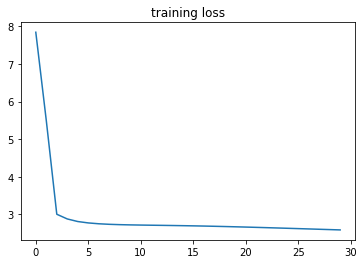

In [102]:
plt.plot(list(range(len(losses))), losses)
plt.title("training loss")
plt.show()

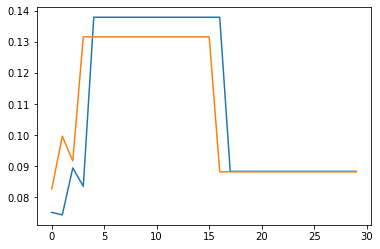

In [103]:
plt.plot(list(range(len(train_accs))), train_accs)
plt.plot(list(range(len(val_accs))), val_accs)
plt.show()